<p align="left">
<img src="figures/Unipd_1.png"  width="300"/> </p>
<p align="left">

<div align="center"> <h2 align="center"> Dipartimento di Fisica e Astronomia "Galileo Galilei" </h2> </div>
<div align="center"> <h2 align="center"> Master degree in Physics of Data</h2> </div>
<div align="center"> <h2 align="center"> Laboratory of Computational Physics, module A </h2> </div>
<div align="center"> <h2 align="center"> Amjadi Bahador, Attar Aidin, Baci Ema, Keshavarzmirzamohammadi Melika </h2> </div>
<br>
<br>





# Volatility Carry Trading Strategy
Volatility is one of the standard measures of risk in financial markets. From a statistical point of
view, volatility is the annualized standard deviation of the yield of an underlying asset.
.
.
.
.


## Table of contents:
- [Theoretical Framework](#intro)
    - [What are Options?](#options)
    - [Volatility](#volatility)
    - [Brownian Motion](#BM)


## **Theoretical Framework** <a class="anchor" id="intro"></a>
In this section, we discuss the theoretical framework which is essential to carry out the project.


### **What are Options?** <a class="anchor" id="options"></a>

Options are contracts that give the bearer the right, but not the obligation, to either buy or sell an amount of some underlying asset at a predetermined price at or before the contract expires.

Depending on the situation, there is usually an option scenario appropriate for an investor’s goal. A popular example would be using options as an effective hedge against a declining stock market to limit downside losses.\
Options belong to the larger group of securities known as derivatives. A derivative's price is dependent on or derived from the price of something else.


#### **Call and Put Options**

Options are a type of derivative security. An option is a derivative because its price is intrinsically linked to the price of something else. If you buy an options contract, it grants you the right but not the obligation to buy or sell an underlying asset at a set price on or before a certain date.

A call option gives the holder the right to buy a stock and a put option gives the holder the right to sell a stock. Think of a call option as a down payment on a future purchase and a put option as an insurance policy.

There are four things you can do with options:

    1. Buy (long) calls
    2. Sell (short) calls
    3. Buy (long) puts
    4. Sell (short) puts
Buying stock gives you a long position. Buying a call option gives you a potential long position in the underlying stock. Short-selling a stock gives you a short position. Selling a naked or uncovered call gives you a potential short position in the underlying stock.

Buying a put option gives you a potential short position in the underlying stock. Selling a naked or unmarried put gives you a potential long position in the underlying stock. Keeping these four scenarios straight is crucial.

People who buy options are called holders and those who sell options are called writers of options.

<p align="left">
<img src="figures/call option1.png"  width="750"/> </p>
<!-- <img src="figures/put option.png"  width="500"/> </p> -->
<p align="left"> 


# Volatility

Volatility often refers to the amount of uncertainty or risk related to the size of changes in a security's value. A higher volatility means that a security's value can potentially be spread out over a larger range of values. This means that the price of the security can change dramatically over a short time period in either direction. It is calculated as standard deviation from expected price.




# Brownian Motion(random walk)


Brownian motion describes movements of a particle which are caused by small shocks from other particles. The particle shows two types of movements:

1.drift: as it is depicted, this movement causes the particle to go away from the first position.

2.fluctuation: the uncertainty or the noise of the movement, that sometimes can change the whole direction of drift movements.



$${dx}= {adt}+{bdz}$$



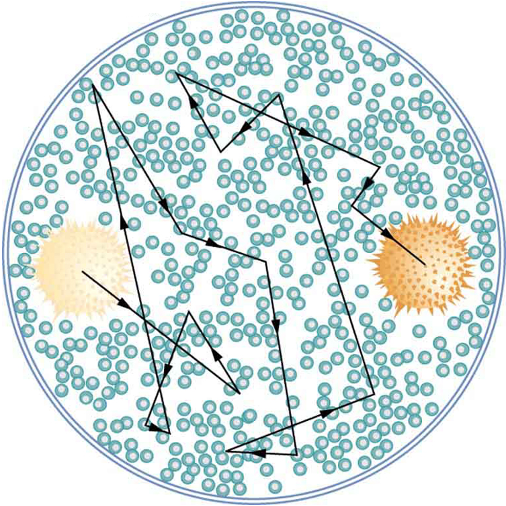

In [226]:
from IPython.display import Image
Image('figures/p.png', width= 200, height = 100)

<div>
<img src="attachment:figures/picture1.png" width="500"/>
</div>

If we scrutinize stock price trajectories, we understand that the stock prices follow the uncertain fashion as well.


### Brownian Motion model of Stock Price
A widely used model for the stock price behaviour is the ***Geometric Brownian Motion (GBM)*** model of stock price:
<br>



$$dS =\mu Sdt+\sigma Sdz$$ 
or in its more formal shape:
$$ \frac{dS}{S} = \mu dt+\sigma dz$$

S: Stock Price <br>
$\mu$: Stock's expected rate of return  <br>
$\sigma$ : Volatility of the Stock Price
Which, From the point of view of physics, is called a ***Generalized Wiener Process***. a process in which The mean change per unit time for a stochastic process is known as the drift rate and the variance per unit time is known as the variance rate.
<br>
<br>
<p align="left">
<img src="figures/GWP.png"  width="700"/> </p> 
<p align="left">
    
Notice: The stock price itself does not follow a generlaized wiener process. we need to normalize the change in stock price at each time w.r.t the stock price in that time. In other words, the variable that satisfies the generalized wiener process equation is the change of stock price in time t, over the stock price in the same time, which is called ***Return***:



#  Ito Lemma

For each variable like x  that follows brownian motion, a function like C, which is a function of x and time, follows brownian motion as well:


$${dx}= {adt}+{bdz}$$


$$
{dC}=\displaystyle \bigg [\frac{\partial C}{\partial x}{a}+\frac{\partial C}{\partial t}+ {1/2}\frac{\partial^{2} C}{\partial x^{2}}{b^{2}}\bigg]{dt} + \frac{\partial C}{\partial x}{b}{dz}
$$


###### As it can be seen the variable C again has two terms; drift rate, and variance rate.





If we go back to option pricing again, C can be fitted to call option price which is a function of stock price (or the underlying asset) and time. This results to the fact that call option prices follow brownian motion too.


## Black-Schoels Model

In 1997, Scholes, Black, and Merton were awarded the Nobel Price because of finding a function that not only does it well describe the call option pricing based on the stock price at current time, but also it is a perfect solution to Ito Lemma's equation.

In the Derivation of Black-Scholes formula, there are some basic assumptions about the market that had been taken into account:
1. No dividends are paid out during the life of the option.

2. Markets are random(market movements cannot be predicted).

3. There are no transaction costs in buying the option.

4. The volatility of the underlying asset is constant.

5. The option is European.


###### The so called Black and Scholes formula for option pricing:


$$
{C}= {S}_{t} {N({d}_{1})} - {K} e^{-rt} {N({d}_{2})}
$$

where : 

$${d}_{1}=\frac{\ln\frac{{S}_{t}}{K} + (r + \frac{{\sigma}_{v}^2}{2})t}{{{\sigma}_{s}}{\sqrt {t}}}
$$

and

$$
{d}_{2}= {d}_{1} - {{\sigma}_{s}}{\sqrt {t}}
$$



where : 

###### C = Call option price
###### S = Current stock price
###### K = Strike price 
###### r = Risk-Free interest rate
###### t = Time to maturity
###### N = A normal distribution




one of the well-accepted strategies to show the market wellbeing is to plot volatility. stock market scientists usally use Black and Scholes model to derive the volatility rather than the option price itself. option price is usually derived from other models and used in Black and Sholes model to plot **Implied Volatility**.

### the most important drawback of Black and Sholes model:



The volatility obtained from model above is constant for every maturity time, which does not square with reality.


That is why we introduce a finer model with more parameters to introduce a volatility that changes over time and gives the investers a better clue about the changes of option prices.

![figures/Screenshot%202022-02-28%20at%2022.55.11.png](figures/attachment:Screenshot%202022-02-28%20at%2022.55.11.png)


# Heston Model


The Heston Model, developed by associate finance professor Steven Heston in 1993, is an option pricing model that can be used for pricing options on various securities. Quite opposite to the Black and Scholes model, This model uses a type of volatility **(Stochastic Volatility)** that changes over time.

##### what is Stochastic volatility
stochastic means the volatility is quite arbitary and random, this means in Heston model we are going to consider a distribution function for deriving this random numbers. this random numbers does not depend on past experiences theonly thing that they are dependent on is the current number. Therefore, we can conclude our volatility follows brownian motion as well.

#### Heston formula

$$ {dS}_{t} = {r}{S}_{t}{dt} + \sqrt {V}_{t} {S}_{t} {dW}_{1t}$$


and :

$$ {dV}_{t} = k({\theta}- {V}_{t}){dt} + {\sigma}{\sqrt {V}_{t}{dW}_{2t}}
$$




### CIR Process



# What's the Goal?


The main goals of the project is listed as below:

#### 1. Modelling the implicit volatility, using multi-factor statistical models.
#### 2.  Creating signals that tell us when to open and close short positions.
#### 3. Estimation of the confidence we have about opening a position



## 1. Modelling the implicit volatility



## 2.  Creating signals that tell us when to open and close short positions



## 3. Estimation of the confidence we have about opening a position





# Data Structure

In the following is reported an analysis of the volatility index (VIX) concerning the Standard & Poor’s 500, the most important North American stock index and the main equity benchmark for Wall Street listed stocks,
in particular we made a parallel anaysis for the first and second future.

Our analysis is based on the Heston Model, that we used to compute the predicted volatility for the following day, then we implement two different investing strategy amd compute the profit for both the two strategies.

To implement the Heston Model we used several techiques to discretize the differential equation such as the Euler method, the Milstein method and the Runge Kutta with four points.


# The Code

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd

import numpy.random as npr

from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from scipy import optimize
from scipy import stats
from scipy import integrate

#import QuantLib as ql
import copy

npr.seed(12345)

%matplotlib inline

In [228]:
dir       = 'data/'
file_name = 'grid1_zheb51fo.xlsx'

UX1       = pd.read_excel(dir+file_name, sheet_name='UX1_Index')
UX2       = pd.read_excel(dir+file_name, sheet_name='UX2_Index')
UX1       = UX1.set_index('Date')
UX2       = UX2.set_index('Date')

UX1.sort_index(inplace=True)
UX2.sort_index(inplace=True)

UX1

,PX_LAST,PX_VOLUME
Date,,
2010-01-04,24.8500,3138
2010-01-05,24.4500,1936
2010-01-06,23.5500,1958
2010-01-07,23.1500,1760
2010-01-08,22.5500,2050
...,...,...
2022-01-12,20.9713,76675
2022-01-13,22.0944,82700
2022-01-14,21.7462,102849


Historical data of SPX price found at https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

In [229]:
file_name         = 'SPX_HistoricalData.csv'
SPX_price         = pd.read_csv(dir+file_name)
SPX_price['Date'] = pd.to_datetime(SPX_price['Date'],format='%m/%d/%y')
SPX_price         = SPX_price.set_index('Date')
SPX_price.sort_index(inplace=True)
SPX_price

,Open,High,Low,Close
Date,,,,
2010-04-01,1171.23,1181.43,1170.69,1178.10
2010-04-05,1178.71,1187.73,1178.71,1187.44
2010-04-06,1186.01,1191.80,1182.77,1189.44
2010-04-07,1188.23,1189.60,1177.25,1182.45
2010-04-08,1181.75,1188.55,1175.12,1186.44
...,...,...,...,...
2022-01-10,4655.34,4673.02,4582.24,4670.29
2022-01-11,4669.14,4714.13,4638.27,4713.07
2022-01-12,4728.59,4748.83,4706.71,4726.35


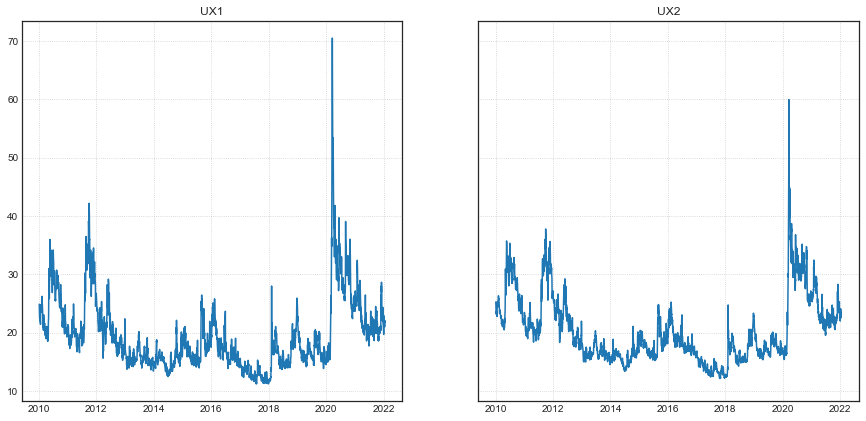

In [230]:
fig,ax = plt.subplots(ncols=2, figsize=(15,7), sharey=True)
ax[0].plot(UX1.index, UX1.PX_LAST)
ax[1].plot(UX2.index, UX2.PX_LAST)
ax[0].set_title('UX1')
ax[1].set_title('UX2')
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')
plt.show()

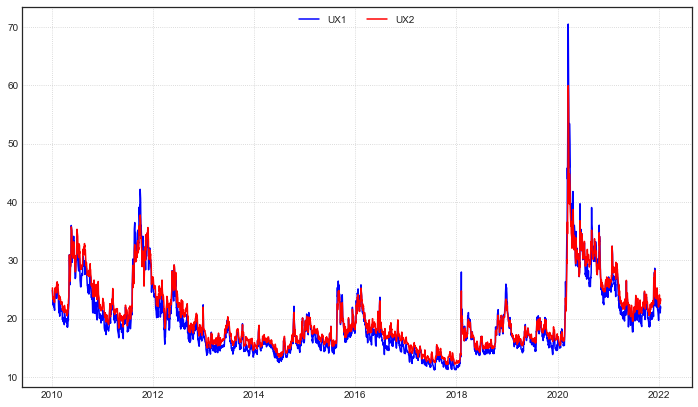

In [231]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax.plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax.legend(loc='upper center', ncol=2)
ax.grid(linestyle='dotted')
plt.show()

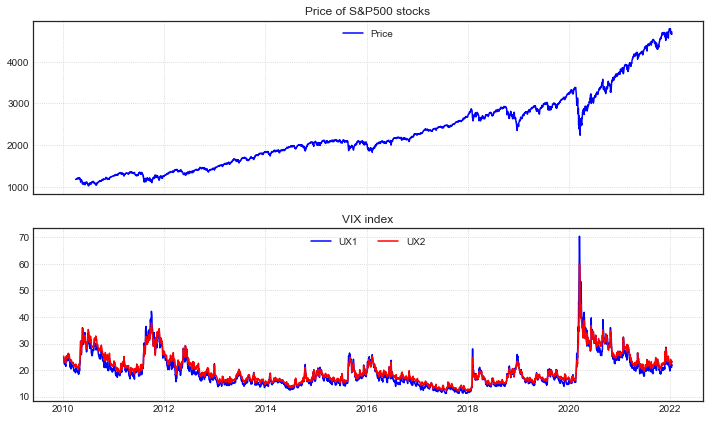

In [232]:
fig,ax = plt.subplots(nrows=2,figsize=(12,7), sharex=True)
ax[0].plot(SPX_price.index, SPX_price.Close, label='Price', color='blue')
ax[0].legend(loc='upper center', ncol=2)
ax[0].grid(linestyle='dotted')
ax[0].set_title('Price of S&P500 stocks')

ax[1].plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax[1].plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax[1].legend(loc='upper center', ncol=2)
ax[1].grid(linestyle='dotted')
ax[1].set_title('VIX index')
plt.show()

## Heston Model

(array([  7.,  39., 130., 324., 484., 501., 343., 127.,  38.,   7.]),
 array([-12.1863784 ,  -9.54592368,  -6.90546896,  -4.26501424,
         -1.62455952,   1.01589521,   3.65634993,   6.29680465,
          8.93725937,  11.57771409,  14.21816882]),
 <BarContainer object of 10 artists>)

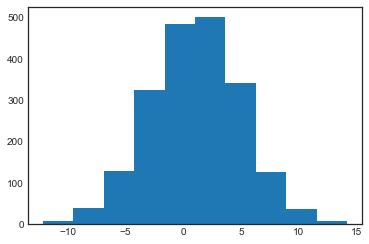

In [82]:
plt.style.use('seaborn-white')
x = np.random.normal(loc=1.0, scale=4, size=2000)

plt.hist(x)


In [233]:
start     = '2010-04-05'
stop      = '2022-01-14'
mask      = ( UX1.index       >= start ) & ( UX1.index       < stop )
UX1       =   UX1[      mask]
mask      = ( UX2.index       >= start ) & ( UX2.index       < stop )
UX2       =   UX2[      mask]
mask      = ( SPX_price.index >= start ) & ( SPX_price.index < stop )
SPX_price =   SPX_price[mask]

UX1       = UX1.drop(UX1.drop(SPX_price.index).index)
UX1       = UX2.drop(UX2.drop(SPX_price.index).index)

In [93]:
rho = 0.999
x = np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size = 1 )
print(x)

[[-0.33647243 -0.32692172]]


In [234]:
def heston_pde_euler(   T,     k,  theta, 
                      v_0, sigma,  steps, Npaths ):
    dt         = 1
    size       = ( Npaths, steps )
    volatility = np.zeros(         size )
    v_t        = np.full ( Npaths,  v_0 )
    for t in range( steps ):
        #WT  = np.sqrt( dt ) * np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size=Npaths )
        WT  = np.sqrt( dt ) * np.random.normal( 0, sigma , size = Npaths )
        v_t = np.abs(    v_t +   k * ( theta - v_t ) * dt + sigma * np.sqrt( v_t ) * WT )

        volatility[:,t] = v_t
    return volatility

In [235]:
def heston_pde_milstein(   T,     k, theta,   
                         v_0, sigma, steps, Npaths ):
    dt         = 1
    size       = ( Npaths, steps )
    volatility = np.zeros(         size )
    v_t        = np.full ( Npaths,  v_0 )
    for t in range( steps ):
        #WT  = np.sqrt( dt ) * np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size=Npaths )
        WT  = np.sqrt( dt ) * np.random.normal( 0, sigma , size = Npaths )
        v_t = np.abs(    v_t +   k * ( theta - v_t ) * dt + sigma * np.sqrt( v_t ) * WT + .25 * sigma**2 * ( WT**2 - dt ) )

        volatility[:, t] = v_t
    return volatility

In [236]:
def heston_pde_runge_kutta(   T,     k, theta,   
                            v_0, sigma, steps, Npaths ):
    dt         = 1
    size       = (Npaths, steps)
    volatility = np.zeros(size)
    v_t        = np.full(Npaths, v_0)
    v_t_0      = np.full(Npaths, v_0)
    v_t_1      = np.full(Npaths, v_0)
    v_t_2      = np.full(Npaths, v_0)
    v_t_3      = np.full(Npaths, v_0)


    for t in range( steps ):
        #WT       = np.sqrt(dt) * np.random.multivariate_normal(np.array( [0,  0]), np.array([[1,rho], [rho,1]]),size=Npaths)
        WT       = np.sqrt( dt ) * np.random.normal( 0, sigma , size = Npaths )
        v_t_0    = np.abs(v_t_0)
        v_t_1    = np.abs(v_t_1 + (k*(theta - v_t_0) + np.sqrt(1/dt)*sigma*np.sqrt(v_t_0)*WT)*dt/2)
        v_t_2    = np.abs(v_t_1 + (k*(theta - v_t_1) + np.sqrt(1/dt)*sigma*np.sqrt(v_t_1)*WT)*dt/2)
        v_t_3    = np.abs(v_t_2 + (k*(theta - v_t_2) + np.sqrt(1/dt)*sigma*np.sqrt(v_t_2)*WT)*dt)
        v_t      = np.abs(v_t   + (k*(theta - v_t_1) + np.sqrt(1/dt)*sigma*np.sqrt(v_t_1)*WT  +
                                   2*k*(theta - v_t_1)+ np.sqrt(1/dt)*sigma*np.sqrt(v_t_1)*WT +
                                   2*k*(theta - v_t_2)+ np.sqrt(1/dt)*sigma*np.sqrt(v_t_2)*WT )*dt/6)
        volatility[:,t] = v_t
    return volatility

In [237]:
T1      = 30
T2      = 60
steps   = 1
Npaths  = 100
delta   = 1

min       = 5
max       = 101
window    = np.arange( min, max )

volat1    = np.zeros( shape = ( max - min,       UX1.index.size, Npaths ) )
volat2    = np.zeros( shape = ( max - min,       UX2.index.size, Npaths ) )

vol1_mean = np.zeros( shape = ( max - min,       UX1.index.size         ) )
vol2_mean = np.zeros( shape = ( max - min,       UX2.index.size         ) )

for n in window:
    print( '... processing window', n, '...' )

    prices1 = np.empty( ( SPX_price.index.size - n, Npaths ) )
    prices2 = np.empty( ( SPX_price.index.size - n, Npaths ) )
    vol1    = np.empty( (       UX1.index.size - n, Npaths ) )
    vol2    = np.empty( (       UX2.index.size - n, Npaths ) )

    for i in range(n,UX1.index.size):
        Vt1             = UX1.PX_LAST.iloc[    i-n:i].values**2
        Vt2             = UX2.PX_LAST.iloc[    i-n:i].values**2

        V10             = Vt1[-1]
        V20             = Vt2[-1]


        b1 = np.abs( ( ( 1 / n**2 * sum( Vt1[i  ] for i in range( 1, n ) ) * sum( Vt1[ i - 1 ]**( -1 )  for i in range( 1, n ) ) )   -
                       ( 1 / n    * sum( Vt1[i  ]                          *      Vt1[ i - 1 ]**( -1 )  for i in range( 1, n ) ) ) ) /
                       ( 1 / n**2 * sum( Vt1[i-1] for i in range( 1, n ) ) * sum( Vt1[ i - 1 ]**( -1 )  for i in range( 1, n ) ) - 1 ) )

        b2 = np.abs( (   1 / n    * sum( Vt1[i  ]                          *      Vt1[ i - 1 ]**( -1 )  for i in range( 1, n ) )       - b1 ) /
                     (              sum(                                          Vt1[ i - 1 ]**( -1 )  for i in range( 1, n ) ) * ( 1 - b1 ) / n ) )

        b3 = np.abs(     1 / n    * sum( ( Vt1[i] - Vt1[i-1] * b1 - b2 * ( 1 - b1 )**2 ) / Vt1[ i - 1 ] for i in range( 1, n ) ) )

        k1 = - np.log( b1 ) / delta
        theta1 = b2
        sigma1 = np.sqrt( 2 * k1 * b3 / ( 1 - b1**2 ) )


        b1 = np.abs( ( ( 1 / n**2 * sum( Vt2[i  ] for i in range( 1, n ) ) * sum( Vt2[ i - 1 ]**( -1 )  for i in range( 1, n ) ) )   -
                       ( 1 / n    * sum( Vt2[i  ]                          *      Vt2[ i - 1 ]**( -1 )  for i in range( 1, n ) ) ) ) /
                       ( 1 / n**2 * sum( Vt2[i-1] for i in range( 1, n ) ) * sum( Vt2[ i - 1 ]**( -1 )  for i in range( 1, n ) ) - 1 ) )

        b2 = np.abs( (   1 / n    * sum( Vt2[i  ]                          *      Vt2[ i - 1 ]**( -1 )  for i in range( 1, n ) )       - b1 ) /
                     (              sum(                                          Vt2[ i - 1 ]**( -1 )  for i in range( 1, n ) ) * ( 1 - b1 ) / n ) )

        b3 = np.abs(     1 / n    * sum( ( Vt2[i] - Vt2[i-1] * b1 - b2 * ( 1 - b1 )**2 ) / Vt2[ i - 1 ] for i in range( 1, n ) ) )

        k2 = - np.log( b1 ) / delta
        theta2 = b2
        sigma2 = np.sqrt( 2 * k2 * b3 / ( 1 - b1**2 ) )
 
        v1          = heston_pde_euler( T1, k1, theta1, V10, sigma1, steps, Npaths )
        v2          = heston_pde_euler( T2, k2, theta2, V20, sigma2, steps, Npaths )
        #v1          = heston_pde_milstein( T1, k1, theta1, V10, sigma1, steps, Npaths )
        #v2          = heston_pde_milstein( T2, k2, theta2, V20, sigma2, steps, Npaths )
        #v1          = heston_pde_runge_kutta( T1, k1, theta1, V10, sigma1, steps, Npaths)
        #v2          = heston_pde_runge_kutta( T2, k2, theta2, V20, sigma2, steps, Npaths)

        vol1[   i-n,:] = v1[:].ravel( )
        vol2[   i-n,:] = v2[:].ravel( )

    vol1      = np.insert( vol1,    0, np.full( ( n, Npaths ), np.nan ), axis = 0 )
    vol2      = np.insert( vol2,    0, np.full( ( n, Npaths ), np.nan ), axis = 0 )

    volat1[ n - min, :, : ] = np.sqrt( vol1 )
    volat2[ n - min, :, : ] = np.sqrt( vol2 )

    vol1_mean[ n - min, : ] = np.sqrt( vol1.mean( axis = 1 ) )
    vol2_mean[ n - min, : ] = np.sqrt( vol2.mean( axis = 1 ) )

... processing window 5 ...
... processing window 6 ...
... processing window 7 ...
... processing window 8 ...
... processing window 9 ...
... processing window 10 ...
... processing window 11 ...
... processing window 12 ...
... processing window 13 ...
... processing window 14 ...
... processing window 15 ...
... processing window 16 ...
... processing window 17 ...
... processing window 18 ...
... processing window 19 ...
... processing window 20 ...
... processing window 21 ...
... processing window 22 ...
... processing window 23 ...
... processing window 24 ...
... processing window 25 ...
... processing window 26 ...
... processing window 27 ...
... processing window 28 ...
... processing window 29 ...
... processing window 30 ...
... processing window 31 ...
... processing window 32 ...
... processing window 33 ...
... processing window 34 ...
... processing window 35 ...
... processing window 36 ...
... processing window 37 ...
... processing window 38 ...
... processing wind

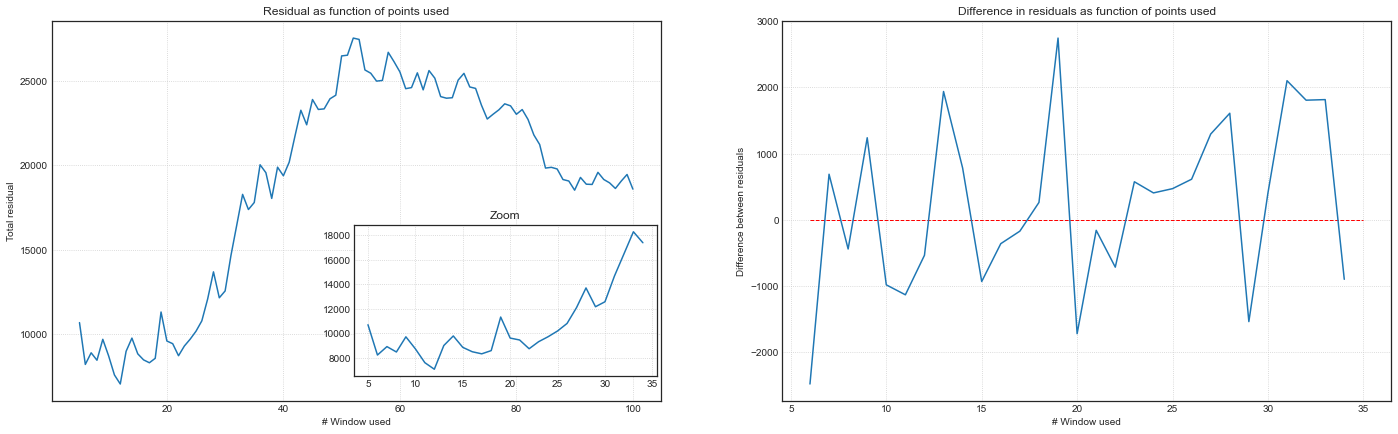

In [238]:
fig, ax = plt.subplots( ncols = 2, figsize=( 24, 7 ) )

ax[ 0 ].plot( np.arange( min, max ), sum( ( vol1_mean[ :, i ] - UX1.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) ) )
ax[ 0 ].set_xlabel('# Window used')
ax[ 0 ].set_ylabel('Total residual')
ax[ 0 ].grid(linestyle='dotted')
ax[ 0 ].set_title('Residual as function of points used')

# An inner plot to zoom
axes = plt.axes( [ 0.3, 0.175, 0.175, 0.3 ] )
axes.set_title( 'Zoom' )
axes.plot( np.arange( 0 + min, 30 + min ), sum( ( vol1_mean[ :, i ] - UX1.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) )[0:30] )
axes.grid( linestyle = 'dotted' )

ax[ 1 ].plot( np.arange( 1 + min, 30 + min ), sum( ( vol1_mean[ 1:30, i ] - UX1.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) ) -
                                              sum( ( vol1_mean[ 0:29, i ] - UX1.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) ) )
ax[ 1 ].hlines( 0, min + 1, 30 + min, lw = 1, color = 'red', linestyle = 'dashed' )
ax[ 1 ].set_xlabel( '# Window used' )
ax[ 1 ].set_ylabel( 'Difference between residuals' )
ax[ 1 ].grid( linestyle = 'dotted' )
ax[ 1 ].set_title( 'Difference in residuals as function of points used' )


plt.show()

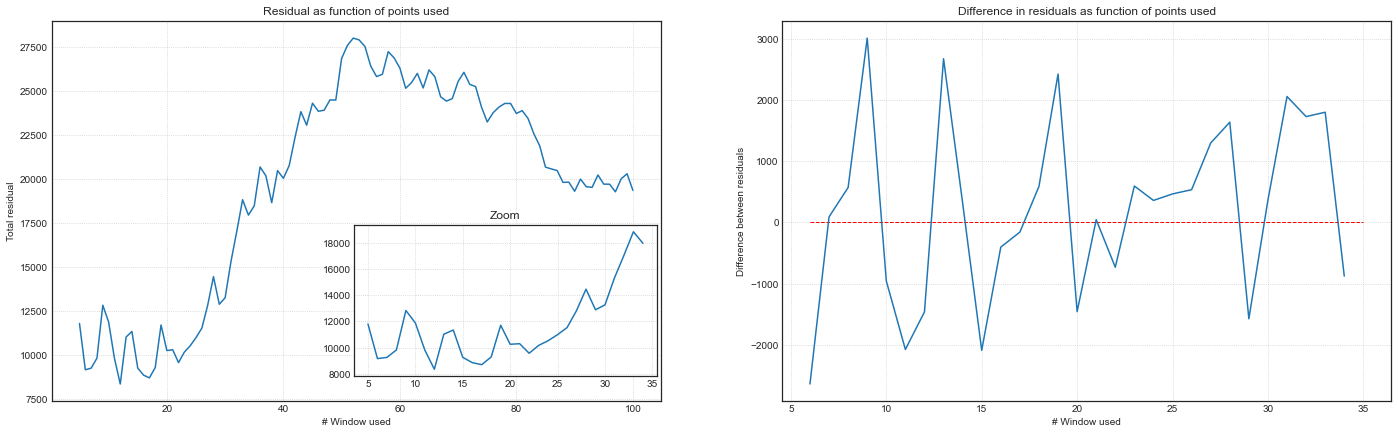

In [239]:
fig, ax = plt.subplots( ncols = 2, figsize=( 24, 7 ) )

ax[ 0 ].plot( np.arange( min, max ), sum( ( vol2_mean[ :, i ] - UX1.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) ) )
ax[ 0 ].set_xlabel('# Window used')
ax[ 0 ].set_ylabel('Total residual')
ax[ 0 ].grid(linestyle='dotted')
ax[ 0 ].set_title('Residual as function of points used')

# An inner plot to zoom
axes = plt.axes( [ 0.3, 0.175, 0.175, 0.3 ] )
axes.set_title( 'Zoom' )
axes.plot( np.arange( 0 + min, 30 + min ), sum( ( vol2_mean[ :, i ] - UX1.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) )[0:30] )
axes.grid( linestyle = 'dotted' )

ax[ 1 ].plot( np.arange( 1 + min, 30 + min ), sum( ( vol2_mean[ 1:30, i ] - UX1.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) ) -
                                              sum( ( vol2_mean[ 0:29, i ] - UX1.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) ) )
ax[ 1 ].hlines( 0, min + 1, 30 + min, lw = 1, color = 'red', linestyle = 'dashed' )
ax[ 1 ].set_xlabel( '# Window used' )
ax[ 1 ].set_ylabel( 'Difference between residuals' )
ax[ 1 ].grid( linestyle = 'dotted' )
ax[ 1 ].set_title( 'Difference in residuals as function of points used' )


plt.show()

In [240]:
index_min_1 = np.argmin( sum( ( vol1_mean[ :, i ] - UX1.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) ) )
index_min_2 = np.argmin( sum( ( vol2_mean[ :, i ] - UX2.PX_LAST.values[ i ] )**2 for i in range( max, UX1.index.size ) ) )
print( 'Window used that gives minimum distance:\t\t', index_min_1 + min)
print( 'Window used that gives minimum distance:\t\t', index_min_2 + min)

UX1[ 'mean_sim' ] = vol1_mean[ index_min_1, : ]
UX2[ 'mean_sim' ] = vol2_mean[ index_min_2, : ]

Window used that gives minimum distance:		 12
Window used that gives minimum distance:		 12


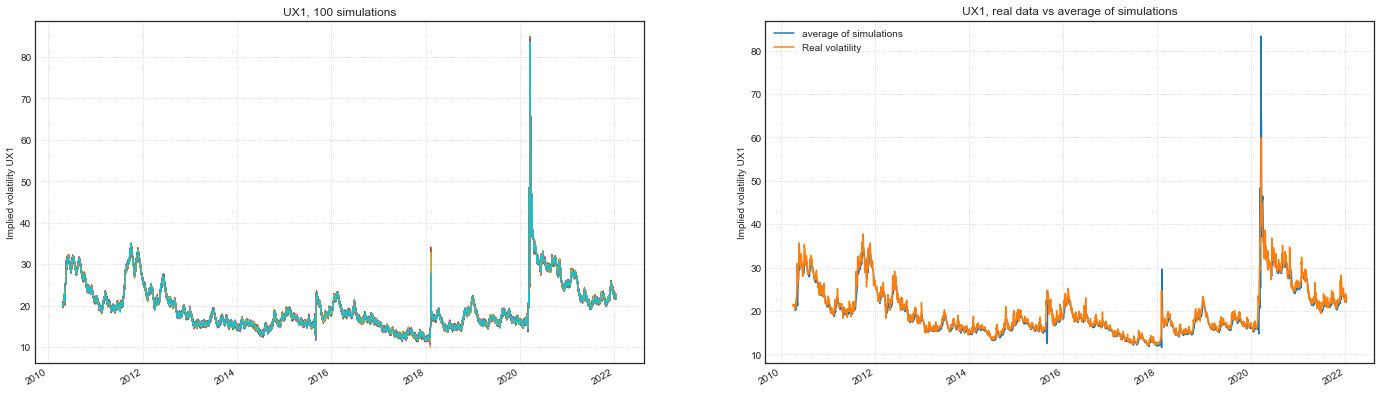

In [241]:
fig, ax = plt.subplots( ncols=2, figsize=( 24, 7 ) )

#ax[0].plot(UX1.index, UX1.PX_LAST, lw=2, label='Real volatility')
for k in range( Npaths ):
    ax[0].plot( UX1.index, volat1[ index_min_1, :, k ], label='', lw=1 )
ax[0].grid( linestyle='dotted' )
#ax[0].legend(loc='upper left')
ax[0].set_title ( 'UX1, ' + str( Npaths ) + ' simulations' )
ax[0].set_ylabel( 'Implied volatility UX1' )

ax[1].plot( UX1.index, UX1['mean_sim'], label='average of simulations' )
ax[1].plot( UX1.index, UX1.PX_LAST, label='Real volatility')
ax[1].grid( linestyle='dotted')
ax[1].legend( loc='upper left')
ax[1].set_title ( 'UX1, real data vs average of simulations')
ax[1].set_ylabel( 'Implied volatility UX1')

fig.autofmt_xdate( )
plt.show()

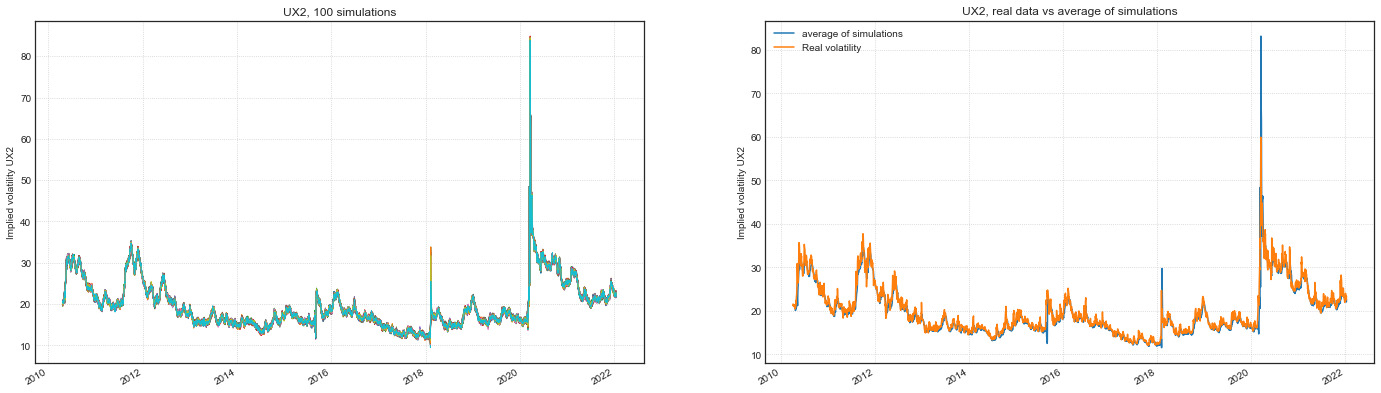

In [242]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

for k in range(Npaths):
    ax[0].plot( UX2.index, volat2[ index_min_2, :, k ], label='', lw=1 )
#ax[0].plot(UX2.index, UX2.PX_LAST, lw=5, label='Real volatility')
ax[0].grid(linestyle='dotted')
#ax[0].legend(loc='best')
ax[0].set_title('UX2, ' + str(Npaths) + ' simulations')
ax[0].set_ylabel('Implied volatility UX2')

ax[1].plot(UX2.index, UX2['mean_sim'], label='average of simulations')
ax[1].plot(UX2.index, UX2.PX_LAST, label='Real volatility')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('UX2, real data vs average of simulations')
ax[1].set_ylabel('Implied volatility UX2')

fig.autofmt_xdate()
plt.show()

In [243]:
UX1[ 'resid' ] = UX1['mean_sim'] - UX1['PX_LAST']
UX2[ 'resid' ] = UX2['mean_sim'] - UX2['PX_LAST']

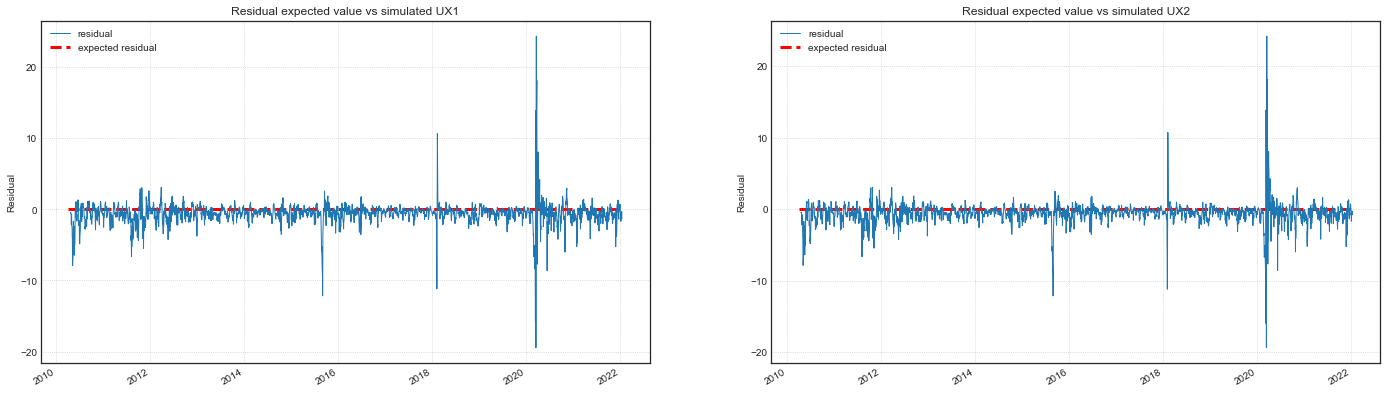

In [244]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

ax[0].plot(UX1.index, UX1.resid, lw=1, label='residual')
ax[0].hlines(0, UX1.index.min(), UX1.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[0].grid(linestyle='dotted')
ax[0].legend(loc='best')
ax[0].set_title('Residual expected value vs simulated UX1')
ax[0].set_ylabel('Residual')

ax[1].plot(UX2.index, UX2.resid, lw=1, label='residual')
ax[1].hlines(0, UX2.index.min(), UX2.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('Residual expected value vs simulated UX2')
ax[1].set_ylabel('Residual')

fig.autofmt_xdate()
plt.show()

N  			=		 229.6113213001126 		+/-		 2.4806709112827976
mu 			=		 -0.40871197427503014 		+/-		 0.007990008210348332
std			=		 0.6404615533784038 		+/-		 0.007990008280730956


R2 			=		 0.9747058925135385 
R 			=		 0.9872719445591162

Covariance matrix:
 [[ 1.         -0.06214987]
 [-0.06214987  1.        ]]

n degrees of freedom 	=		 90

chi2 			=		 322.3059425068975
p-value 		=		 0.0


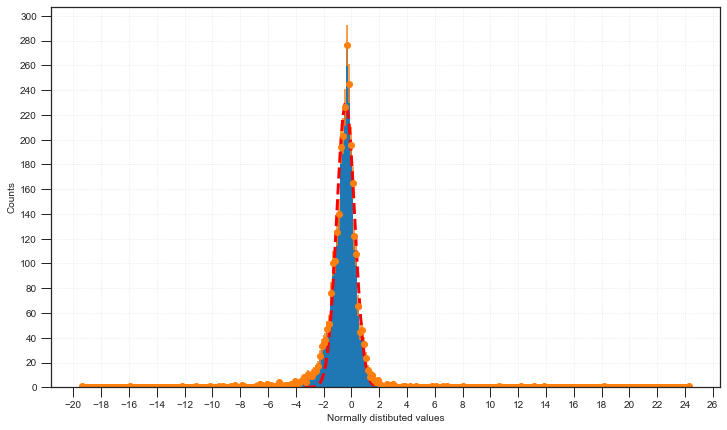

In [245]:
b                 = np.histogram_bin_edges(UX1.resid.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(UX1.resid, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_major_locator(MultipleLocator( 2))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [100,0, 1])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

N  			=		 228.37128963341564 		+/-		 2.45485580642966
mu 			=		 -0.408661532909226 		+/-		 0.007962482184303612
std			=		 0.6414836480839646 		+/-		 0.007962482175102743


R2 			=		 0.974944870114505 
R 			=		 0.9873929664092737

Covariance matrix:
 [[ 1.         -0.06173755]
 [-0.06173755  1.        ]]

n degrees of freedom 	=		 91

chi2 			=		 321.6172004146707
p-value 		=		 0.0


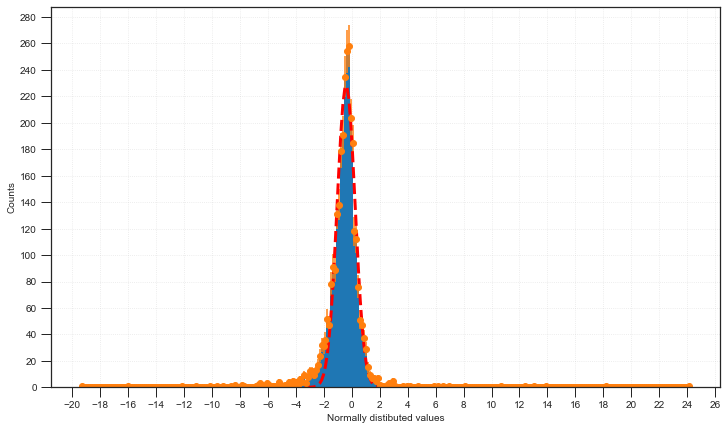

In [246]:
b                 = np.histogram_bin_edges(UX2.resid.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(UX2.resid, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_major_locator(MultipleLocator( 2))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [100,0, 1])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

Sistematic underestimation of volatility

In [247]:
#sns.jointplot(x='mean_sim', y='PX_LAST', data=UX1, kind='reg')

In [248]:
#sns.jointplot(x='mean_sim', y='PX_LAST', data=UX1, kind='resid')

In [249]:
#sns.jointplot(x='mean_sim', y='resid', data=UX1, kind='reg')

## Strategies

### First strategy
The first strategy consists in opening a short position if the predicted VIX for t+1 is less than today's and not closing it untill the predicted VIX for t+1 increases. This first strategy is has a great risk.

### Second strategy
The second strategy consists in opening a short position each time one see the predicted VIX for t+1 is less than today's and closing it the next day. This second strategy should be more conservative.

## First strategy

In [250]:
UX1['diff_sim'] = UX1['PX_LAST'] - UX1['mean_sim'].shift(-1)

conditions = [ ( UX1['diff_sim'] >  0 ),
               ( UX1['diff_sim'] <= 0 ) ]

choices = ['open','close']

UX1['open/close'] = np.select( conditions, choices, default = 0 )

conditions = [ ( UX1['open/close'] ==  'open' ) & ( UX1['open/close'].shift(1) == 'close' ),
               ( UX1['open/close'] == 'close' ) & ( UX1['open/close'].shift(1) ==  'open' ) ]

choices = ['to_open','to_close']

UX1['open/close'] = np.select( conditions, choices, default = UX1['open/close'] )

In [251]:
UX1['diff_sim_real'] =  UX1['PX_LAST'] - UX1['PX_LAST'].shift(-1)

conditions = [ ( UX1['diff_sim_real'] >  0 ),
               ( UX1['diff_sim_real'] <= 0 ) ]

choices = ['open','close']

UX1['open/close_real'] = np.select( conditions, choices, default = 0 )

conditions = [ ( UX1['open/close_real'] ==  'open' ) & ( UX1['open/close_real'].shift(1) == 'close' ),
               ( UX1['open/close_real'] == 'close' ) & ( UX1['open/close_real'].shift(1) ==  'open' ) ]

choices = ['to_open','to_close']

UX1['open/close_real'] = np.select( conditions, choices, default = UX1['open/close_real'] )

In [252]:
UX1['open/close_diff'] = 'correspond'
UX1['open/close_diff'].loc[ UX1['open/close'] != UX1['open/close_real'] ] = 'not correspond'

print( 'Total values processed:\t\t\t\t\t', len(UX1))
print( 'Values predicted that correspond to the real ones:\t', len(UX1[UX1['open/close'] == UX1['open/close_real'].shift(-1)]))

Total values processed:					 2968
Values predicted that correspond to the real ones:	 849


/Users/ema/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [253]:
#fig, ax = plt.subplots( figsize = ( 8, 7 ) )

#entries, edges, _ = ax.hist( UX1['open/close_diff'] )
#ax.set_ylabel( 'Counts' )
#ax.yaxis.set_major_locator( MultipleLocator( 100 ) )
#ax.tick_params( which = 'major',  width = 1.0 )
#ax.tick_params( which = 'major', length = 10  )
#ax.set_title( 'Agreement between real values and predicted ones', fontsize = 16 )

#plt.show()

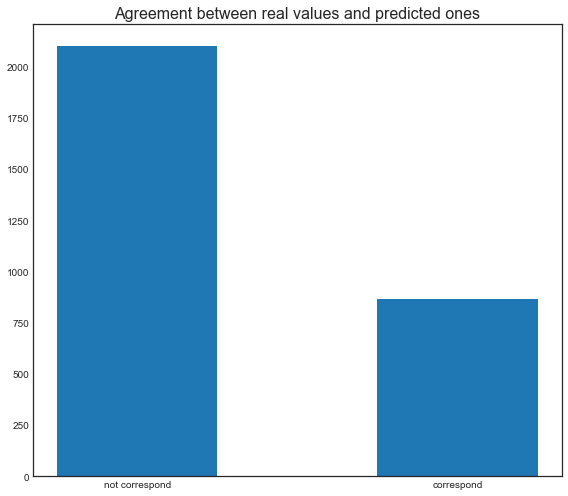

In [332]:
fig, ax = plt.subplots(figsize = ( 8, 7 ))

y = UX1['open/close_diff'].value_counts()
labels = ['not correspond', 'correspond']
xticks = [1,2] 

ax.bar(xticks,y, width = 0.5, align="center")
ax.set_title('Agreement between real values and predicted ones', fontsize = 16)
ax.set_xticks(xticks)
ax.set_xticklabels(labels) 

fig.tight_layout()

In [296]:
#fig, ax = plt.subplots( figsize = ( 12, 7 ) )

#entries, edges, _ = ax.hist( UX1['open/close'], align = 'left' )
#ax.set_ylabel( 'Counts' )
#ax.yaxis.set_major_locator( MultipleLocator( 100 ) )
#ax.tick_params( which = 'major',  width = 1.0 )
#ax.tick_params( which = 'major', length = 10  )
#ax.set_title( 'Counts for each situation', fontsize = 16 )

#plt.show()

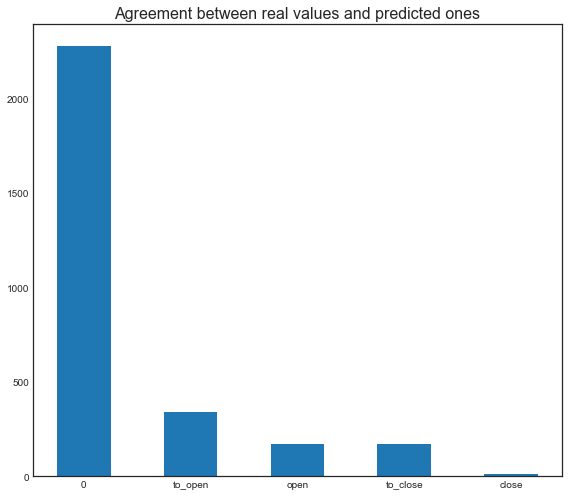

In [333]:
fig, ax = plt.subplots(figsize = ( 8, 7 ))

y = UX1['open/close'].value_counts()
labels = ['0', 'to_open', 'open', 'to_close', 'close']
xticks = [1,2, 3, 4, 5] 

ax.bar(xticks,y, width = 0.5, align="center")
ax.set_title('Agreement between real values and predicted ones', fontsize = 16)
ax.set_xticks(xticks)
ax.set_xticklabels(labels) 

fig.tight_layout()

In [298]:
money = np.zeros( shape = ( len( UX1['PX_LAST'] ) ) )
money[0] = 1000
i = 0
for x in range( 1, len( UX1['PX_LAST'] ) ):
    if UX1['open/close'].iloc[x] == 'to_open':
        money[x] = money[x-1]
        i += 1
    elif UX1['open/close'].iloc[x] == 'open':
        money[x] = money[x-1]
        i += 1
    elif UX1['open/close'].iloc[x] == 'to_close':
        money[x] = money[x-1] + 100 * ( ( UX1['PX_LAST'].iloc[x-i] - UX1['PX_LAST'].iloc[x] ) / UX1['PX_LAST'].iloc[x-i] )
        i = 0
    else:
        money[x] = money[x-1]

In [299]:
money_real = np.zeros(shape=(len(UX1['PX_LAST'])))
money_real[0] = 1000
i = 0
for x in range( 1, len( UX1['PX_LAST'] ) ):
    if UX1['open/close_real'].iloc[x] == 'to_open':
        money_real[x] = money_real[x-1]
        i += 1
    elif UX1['open/close_real'].iloc[x] == 'open':
        money_real[x] = money_real[x-1]
        i += 1
    elif UX1['open/close_real'].iloc[x] == 'to_close':
        money_real[x] = money_real[x-1] + 100 * ( ( UX1['PX_LAST'].iloc[x-i] - UX1['PX_LAST'].iloc[x] ) / UX1['PX_LAST'].iloc[x-i] )
        i = 0
    else:
        money_real[x] = money_real[x-1]

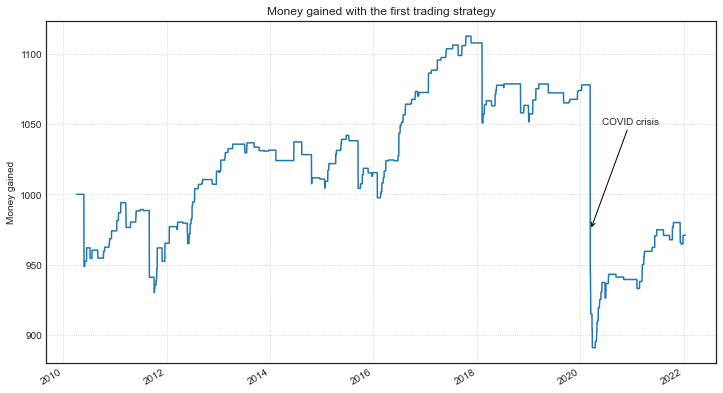

In [300]:
UX1['Money_STR1a'] = money

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

UX1.Money_STR1a.plot( ax = ax )
ax.set_title( 'Money gained with the first trading strategy' )
ax.set_xlabel( '' )
ax.set_ylabel( 'Money gained' )
ax.grid( linestyle = 'dotted' )

ax.annotate( "COVID crisis", xy = ( '2020-03-15', 975 ), xytext = ( '2020-06-01', 1050 ),
             arrowprops = dict( arrowstyle = "->" ) )

plt.show()

## Use of a coaefficient to choose how much to be invested

Instead of investing the same value based only on the prediction

$$
    VIX[t] - VIX[t+1] < 0
$$

we decide to use a coefficient which will be multiplied to the constant arbitrary value. The coefficient should mesure the confidence we have in our bet: we chose the value

$$
    \gamma = VIX_{real}[t] - VIX_{pred}[t+1]
$$

In this way the bet gain will be

$$
    m[i+1] = m[i] + 100\gamma\frac{VIX_{real}[t]-VIX_{real}[t+1]}{VIX_{real}[t]}
$$

Beside this we decide to change even the constant part: we can chose to divide money into severe brackets given by numbers between two powers of 10, i.e. if we have 2000$ we are in the 1000$ bracket. Anyway to have something more efficient and less arbitrary we decide to mix up the factors as follows

$$
    m[i+1] = m[i] + \frac{m[i]}{15}\cdot \tanh\gamma \cdot \frac{VIX_{real}[t]-VIX_{real}[t+1]}{VIX_{real}[t]}
$$

In this way we can potentially deal with both short and long position.

In [301]:
money = np.zeros( shape = ( len( UX1['PX_LAST'] ) ) )
money[0] = 1000
inv_eff = np.array([])
i = 0
investment = []
for x in range( 1, len( UX1['PX_LAST'] ) ):
    if UX1['PX_LAST'].iloc[x] > 20:
        d = 10
    else:
        d = 30

    if UX1['open/close'].iloc[x] == 'to_open': # apro la posizione, metto una parte in investimento
        new_investment = money[ x - 1 ] / d * np.tanh( UX1['diff_sim'].iloc[x] / d )
        money[x]       = money[ x - 1 ]
        investment.append( new_investment )
        i += 1
    elif UX1['open/close'].iloc[x] == 'open': # mantengo la posizione
        new_investment = money[ x - 1 ] / d * np.tanh( UX1['diff_sim'].iloc[x] / d )
        money[x]       = money[ x - 1 ]
        investment.append( new_investment )
        i += 1
    elif UX1['open/close'].iloc[x] == 'to_close': # close the position
        inv_eff = np.append( inv_eff, sum( investment ) )
        gain    = 0
        for j in range( len( investment ) ):
            gain += investment[j] * ( ( UX1['PX_LAST'].iloc[ x - ( len( investment ) - j ) ] - UX1['PX_LAST'].iloc[x] ) / UX1['PX_LAST'].iloc[ x - ( len( investment ) - j ) ] )
        money[x] = money[x-1] + gain
        i = 0
        investment = []
    else:
        money[x] = money[x-1]
    if money[x] < 1 and ( UX1['open/close'].iloc[x] == 'to_close' or 
                          UX1['open/close'].iloc[x] ==    'close'    ):
        money[x:] = money[x]
        break

In [302]:
money_real = np.zeros( shape = ( len( UX1['PX_LAST'] ) ) )
money_real[0] = 1000
inv_eff = np.array( [] )
i = 0
investment = []

#for x in range(1, 200):
for x in range(1, len(UX1['PX_LAST'])):
    if UX1['PX_LAST'].iloc[x] > 20:
        d = 10
    else:
        d = 30

    if UX1['open/close_real'].iloc[x] == 'to_open': # apro la posizione, metto una parte in investimento
        new_investment = money_real[ x - 1 ] / d * np.tanh( UX1['diff_sim_real'].iloc[x] / d )
        money_real[x]  = money_real[ x - 1 ] - new_investment
        investment.append( new_investment )
        i += 1
    elif UX1['open/close_real'].iloc[x] == 'open': # mantengo la posizione
        new_investment = money_real[ x - 1 ] / d * np.tanh( UX1['diff_sim_real'].iloc[x] / d )
        money_real[x]       = money_real[ x - 1 ] - new_investment
        investment.append( new_investment )
        i += 1
    elif UX1['open/close_real'].iloc[x] == 'to_close': # close the position
        inv_eff = np.append( inv_eff, sum( investment ) )
        gain    = 0
        for j in range( len( investment ) ):
            gain += investment[j] * ( 1 + ( UX1['PX_LAST'].iloc[ x - ( len( investment ) - j ) ] - UX1['PX_LAST'].iloc[x] ) / UX1['PX_LAST'].iloc[ x - ( len( investment ) - j ) ] )
        money_real[x] = money_real[x-1] + gain
        i = 0
        investment = []
    else:
        money_real[x] = money_real[x-1]
    if money_real[x] < 1:
        money_real[x:] = money_real[x]
        break

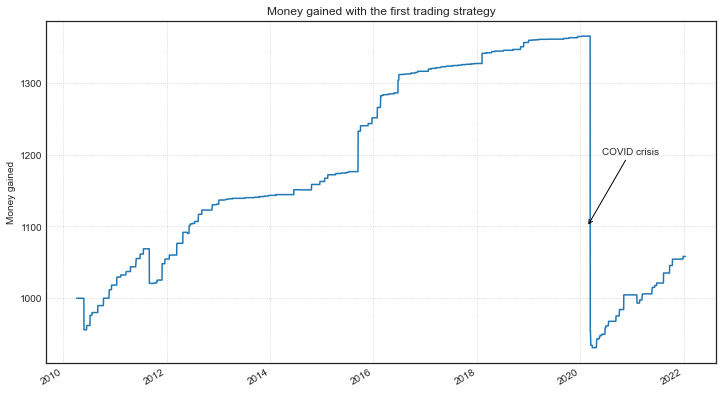

In [303]:
UX1['Money_STR1b'] = money

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

UX1.Money_STR1b.plot( ax = ax )
ax.set_title( 'Money gained with the first trading strategy' )
ax.set_xlabel( '' )
ax.set_ylabel( 'Money gained' )
ax.grid( linestyle = 'dotted' )

ax.annotate( "COVID crisis", xy = ( '2020-02-20', 1100 ), xytext = ( '2020-06-01', 1200 ),
             arrowprops = dict( arrowstyle = "->" ) )

plt.show()

## Second strategy

In [304]:
conditions = [ ( UX1['diff_sim'] >  0 ),
               ( UX1['diff_sim'] <= 0 ) ]

choices = ['open','close']

UX1['open/close_2'] = np.select( conditions, choices, default = 0 )

In [305]:
conditions = [ ( UX1['diff_sim_real'] >  0 ),
               ( UX1['diff_sim_real'] <= 0 ) ]

choices = ['open','close']

UX1['open/close_real_2'] = np.select( conditions, choices, default = 0 )

In [306]:
money_2 = np.zeros( shape = ( len( UX1['PX_LAST'] ) ) )
money_2[0] = 1000
for x in range( 1, len( UX1['PX_LAST'] ) ):
    if UX1['open/close_2'].iloc[x] == 'open':
        money_2[x] = money_2[x-1] + 100 * ( ( UX1['PX_LAST'].iloc[x] - UX1['PX_LAST'].iloc[x+1] ) / UX1['PX_LAST'].iloc[x] )
    else:
        money_2[x] = money_2[x-1]

In [307]:
money_real_2 = np.zeros( shape = ( len( UX1['PX_LAST'] ) ) )
money_real_2[0] = 1000
for x in range( 1, len( UX1['PX_LAST'] ) ):
    if UX1['open/close_real_2'].iloc[x] == 'open':
        money_real_2[x] = money_real_2[x-1] + 100 * ( ( UX1['PX_LAST'].iloc[x] - UX1['PX_LAST'].iloc[x+1] ) / UX1['PX_LAST'].iloc[x] )
    else:
        money_real_2[x] = money_real_2[x-1]

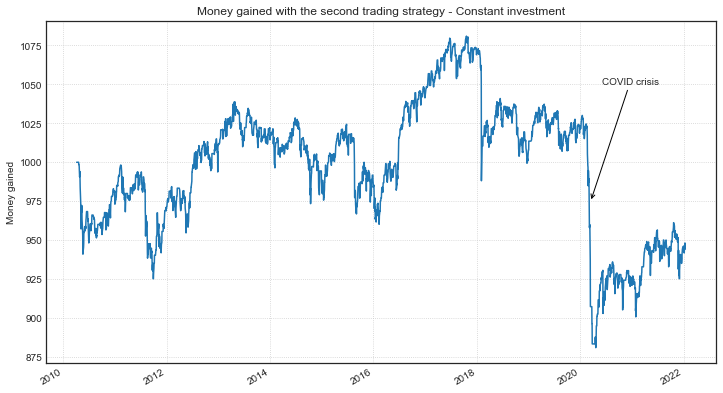

In [308]:
UX1['Money_STR2a'] = money_2

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

UX1.Money_STR2a.plot( ax = ax )
ax.set_title( 'Money gained with the second trading strategy - Constant investment' )
ax.set_xlabel( '' )
ax.set_ylabel( 'Money gained' )
ax.grid( linestyle = 'dotted' )

ax.annotate( "COVID crisis", xy = ( '2020-03-15', 975 ), xytext = ( '2020-06-01', 1050 ),
             arrowprops = dict( arrowstyle = "->" ) )

plt.show()

In [309]:
money_2 = np.zeros( shape = ( len( UX1['PX_LAST'] ) ) )
money_2[0] = 1000
for x in range( 1, len( UX1['PX_LAST'] ) ):
    if UX1['open/close_2'].iloc[x] == 'open':
        if UX1['PX_LAST'].iloc[x] > 20:
            d = 1.5
        else:
            d = 15
        money_2[x] = money_2[x-1] + money_2[x-1] / d * np.tanh( UX1['diff_sim'].iloc[x] / d ) * ( ( UX1['PX_LAST'].iloc[x] - UX1['PX_LAST'].iloc[x+1] ) / UX1['PX_LAST'].iloc[x] )
    else:
        money_2[x] = money_2[x-1]

In [310]:
money_real_2 = np.zeros( shape = ( len( UX1['PX_LAST'] ) ) )
money_real_2[0] = 1000
for x in range( 1, len( UX1['PX_LAST'] ) ):
    if UX1['open/close_real_2'].iloc[x] == 'open':
        if UX1['PX_LAST'].iloc[x] > 20:
            d = 1.5
        else:
            d = 15
        money_real_2[x] = money_real_2[x-1] + money_real_2[x-1] / d * np.tanh( UX1['diff_sim_real'].iloc[x] / d ) * ( ( UX1['PX_LAST'].iloc[x] - UX1['PX_LAST'].iloc[x+1] ) / UX1['PX_LAST'].iloc[x] )
    else:
        money_real_2[x] = money_real_2[x-1]

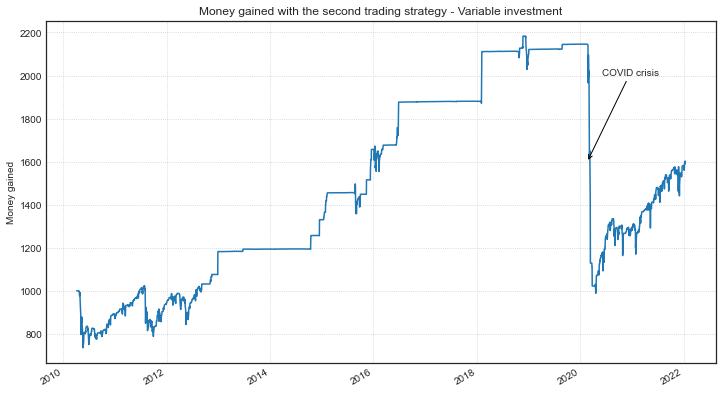

In [311]:
UX1['Money_STR2b'] = money_2

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

UX1.Money_STR2b.plot( ax = ax )
ax.set_title( 'Money gained with the second trading strategy - Variable investment' )
ax.set_xlabel( '' )
ax.set_ylabel( 'Money gained' )
ax.grid( linestyle = 'dotted' )

ax.annotate( "COVID crisis", xy = ( '2020-02-20', 1600 ), xytext = ( '2020-06-01', 2000 ),
             arrowprops = dict( arrowstyle = "->" ) )

plt.show()

In [312]:
UX2['diff_sim'] = UX2['PX_LAST'] - UX2['mean_sim'].shift(-1)

conditions = [ ( UX2['diff_sim'] >  0 ),
               ( UX2['diff_sim'] <= 0 ) ]

choices = ['open','close']

UX2['open/close'] = np.select( conditions, choices, default = 0 )

conditions = [ ( UX2['open/close'] ==  'open' ) & ( UX2['open/close'].shift(1) == 'close' ),
               ( UX2['open/close'] == 'close' ) & ( UX2['open/close'].shift(1) ==  'open' ) ]

choices = ['to_open','to_close']

UX2['open/close'] = np.select( conditions, choices, default = UX2['open/close'] )

In [313]:
UX2['diff_sim_real'] =  UX2['PX_LAST'] - UX2['PX_LAST'].shift(-1)

conditions = [ ( UX2['diff_sim_real'] >  0 ),
               ( UX2['diff_sim_real'] <= 0 ) ]

choices = ['open','close']

UX2['open/close_real'] = np.select( conditions, choices, default = 0 )

conditions = [ ( UX2['open/close_real'] ==  'open' ) & ( UX2['open/close_real'].shift(1) == 'close' ),
               ( UX2['open/close_real'] == 'close' ) & ( UX2['open/close_real'].shift(1) ==  'open' ) ]

choices = ['to_open','to_close']

UX2['open/close_real'] = np.select( conditions, choices, default = UX2['open/close_real'] )

In [314]:
UX2['open/close_diff'] = 'correspond'
UX2['open/close_diff'].loc[ UX2['open/close'] != UX2['open/close_real'] ] = 'not correspond'

print( 'Total values processed:\t\t\t\t\t', len(UX2))
print( 'Values predicted that correspond to the real ones:\t', len(UX2[UX2['open/close'] == UX2['open/close_real'].shift(-1)]))

Total values processed:					 2969
Values predicted that correspond to the real ones:	 843


/Users/ema/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [335]:
#fig, ax = plt.subplots( figsize = ( 8, 7 ) )

#entries, edges, _ = ax.hist( UX2['open/close_diff'] )
#ax.set_ylabel( 'Counts' )
#ax.yaxis.set_major_locator( MultipleLocator( 100 ) )
#ax.tick_params( which = 'major',  width = 1.0 )
#ax.tick_params( which = 'major', length = 10  )
#ax.set_title( 'Agreement between real values and predicted ones', fontsize = 16 )

#plt.show()

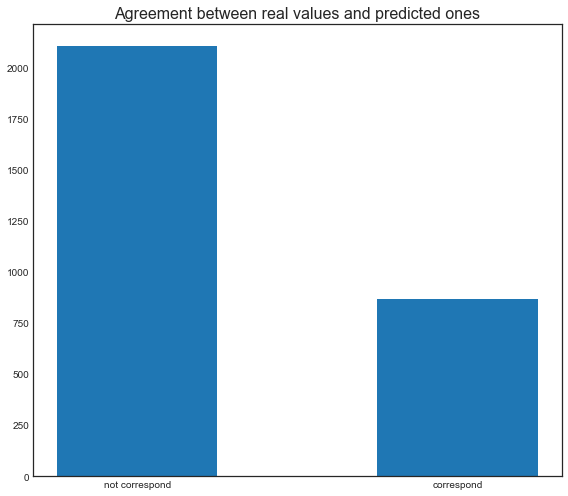

In [336]:
fig, ax = plt.subplots(figsize = ( 8, 7 ))

y = UX2['open/close_diff'].value_counts()
labels = ['not correspond', 'correspond']
xticks = [1,2] 

ax.bar(xticks,y, width = 0.5, align="center")
ax.set_title('Agreement between real values and predicted ones', fontsize = 16)
ax.set_xticks(xticks) 
ax.set_xticklabels(labels) 

fig.tight_layout()

In [337]:
#fig, ax = plt.subplots( figsize = ( 12, 7 ) )

#entries, edges, _ = ax.hist( UX2['open/close'], align = 'left' )
#ax.set_ylabel( 'Counts' )
#ax.yaxis.set_major_locator( MultipleLocator( 100 ) )
#ax.tick_params( which = 'major',  width = 1.0 )
#ax.tick_params( which = 'major', length = 10  )
#ax.set_title( 'Counts for each situation', fontsize = 16 )

#plt.show()

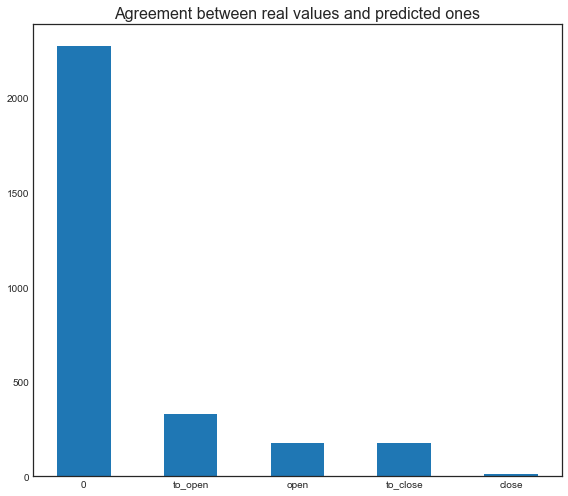

In [338]:
fig, ax = plt.subplots(figsize = ( 8, 7 ))

y = UX2['open/close'].value_counts()
labels = ['0', 'to_open', 'open', 'to_close', 'close']
xticks = [1,2, 3, 4, 5] 

ax.bar(xticks,y, width = 0.5, align="center")
ax.set_title('Agreement between real values and predicted ones', fontsize = 16)
ax.set_xticks(xticks)
ax.set_xticklabels(labels) 

fig.tight_layout()

In [339]:
money = np.zeros( shape = ( len( UX2['PX_LAST'] ) ) )
money[0] = 1000
i = 0
for x in range( 1, len( UX2['PX_LAST'] ) ):
    if UX2['open/close'].iloc[x] == 'to_open':
        money[x] = money[x-1]
        i += 1
    elif UX2['open/close'].iloc[x] == 'open':
        money[x] = money[x-1]
        i += 1
    elif UX2['open/close'].iloc[x] == 'to_close':
        money[x] = money[x-1] + 100 * ( ( UX2['PX_LAST'].iloc[x-i] - UX2['PX_LAST'].iloc[x] ) / UX2['PX_LAST'].iloc[x-i] )
        i = 0
    else:
        money[x] = money[x-1]

In [340]:
money_real = np.zeros(shape=(len(UX2['PX_LAST'])))
money_real[0] = 1000
i = 0
for x in range( 1, len( UX2['PX_LAST'] ) ):
    if UX2['open/close_real'].iloc[x] == 'to_open':
        money_real[x] = money_real[x-1]
        i += 1
    elif UX2['open/close_real'].iloc[x] == 'open':
        money_real[x] = money_real[x-1]
        i += 1
    elif UX2['open/close_real'].iloc[x] == 'to_close':
        money_real[x] = money_real[x-1] + 100 * ( ( UX2['PX_LAST'].iloc[x-i] - UX2['PX_LAST'].iloc[x] ) / UX2['PX_LAST'].iloc[x-i] )
        i = 0
    else:
        money_real[x] = money_real[x-1]

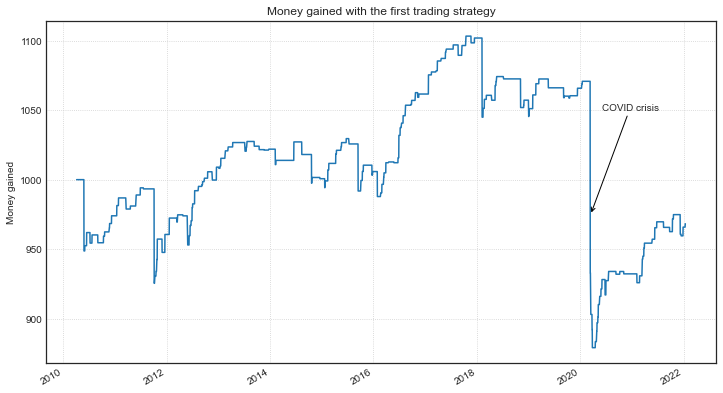

In [341]:
UX2['Money_STR1a'] = money

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

UX2.Money_STR1a.plot( ax = ax )
ax.set_title( 'Money gained with the first trading strategy' )
ax.set_xlabel( '' )
ax.set_ylabel( 'Money gained' )
ax.grid( linestyle = 'dotted' )

ax.annotate( "COVID crisis", xy = ( '2020-03-15', 975 ), xytext = ( '2020-06-01', 1050 ),
             arrowprops = dict( arrowstyle = "->" ) )

plt.show()

In [342]:
money = np.zeros( shape = ( len( UX2['PX_LAST'] ) ) )
money[0] = 1000
inv_eff = np.array([])
i = 0
investment = []
for x in range( 1, len( UX2['PX_LAST'] ) ):
    if UX2['PX_LAST'].iloc[x] > 20:
        d = 10
    else:
        d = 30

    if UX2['open/close'].iloc[x] == 'to_open': # apro la posizione, metto una parte in investimento
        new_investment = money[ x - 1 ] / d * np.tanh( UX2['diff_sim'].iloc[x] / d )
        money[x]       = money[ x - 1 ]
        investment.append( new_investment )
        i += 1
    elif UX2['open/close'].iloc[x] == 'open': # mantengo la posizione
        new_investment = money[ x - 1 ] / d * np.tanh( UX2['diff_sim'].iloc[x] / d )
        money[x]       = money[ x - 1 ]
        investment.append( new_investment )
        i += 1
    elif UX2['open/close'].iloc[x] == 'to_close': # close the position
        inv_eff = np.append( inv_eff, sum( investment ) )
        gain    = 0
        for j in range( len( investment ) ):
            gain += investment[j] * ( ( UX2['PX_LAST'].iloc[ x - ( len( investment ) - j ) ] - UX2['PX_LAST'].iloc[x] ) / UX2['PX_LAST'].iloc[ x - ( len( investment ) - j ) ] )
        money[x] = money[x-1] + gain
        i = 0
        investment = []
    else:
        money[x] = money[x-1]
    if money[x] < 1 and ( UX2['open/close'].iloc[x] == 'to_close' or 
                          UX2['open/close'].iloc[x] ==    'close'    ):
        money[x:] = money[x]
        break

In [343]:
money_real = np.zeros( shape = ( len( UX2['PX_LAST'] ) ) )
money_real[0] = 1000
inv_eff = np.array( [] )
i = 0
investment = []

#for x in range(1, 200):
for x in range(1, len(UX2['PX_LAST'])):
    if UX2['PX_LAST'].iloc[x] > 20:
        d = 10
    else:
        d = 30

    if UX2['open/close_real'].iloc[x] == 'to_open': # apro la posizione, metto una parte in investimento
        new_investment = money_real[ x - 1 ] / d * np.tanh( UX2['diff_sim_real'].iloc[x] / d )
        money_real[x]  = money_real[ x - 1 ]
        investment.append( new_investment )
        i += 1
    elif UX2['open/close_real'].iloc[x] == 'open': # mantengo la posizione
        new_investment = money_real[ x - 1 ] / d * np.tanh( UX2['diff_sim_real'].iloc[x] / d )
        money_real[x]       = money_real[ x - 1 ]
        investment.append( new_investment )
        i += 1
    elif UX2['open/close_real'].iloc[x] == 'to_close': # close the position
        inv_eff = np.append( inv_eff, sum( investment ) )
        gain    = 0
        for j in range( len( investment ) ):
            gain += investment[j] * ( ( UX2['PX_LAST'].iloc[ x - ( len( investment ) - j ) ] - UX2['PX_LAST'].iloc[x] ) / UX2['PX_LAST'].iloc[ x - ( len( investment ) - j ) ] )
        money_real[x] = money_real[x-1] + gain
        i = 0
        investment = []
    else:
        money_real[x] = money_real[x-1]
    if money_real[x] < 1:
        money_real[x:] = money_real[x]
        break

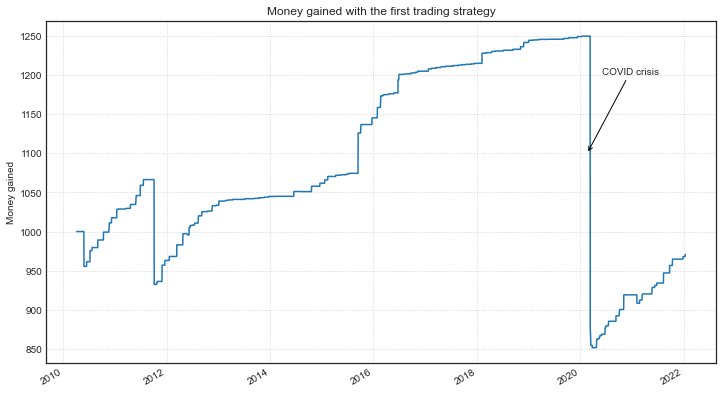

In [344]:
UX2['Money_STR1b'] = money

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

UX2.Money_STR1b.plot( ax = ax )
ax.set_title( 'Money gained with the first trading strategy' )
ax.set_xlabel( '' )
ax.set_ylabel( 'Money gained' )
ax.grid( linestyle = 'dotted' )

ax.annotate( "COVID crisis", xy = ( '2020-02-20', 1100 ), xytext = ( '2020-06-01', 1200 ),
             arrowprops = dict( arrowstyle = "->" ) )

plt.show()

## Second strategy

In [345]:
conditions = [ ( UX2['diff_sim'] >  0 ),
               ( UX2['diff_sim'] <= 0 ) ]

choices = ['open','close']

UX2['open/close_2'] = np.select( conditions, choices, default = 0 )

In [346]:
conditions = [ ( UX2['diff_sim_real'] >  0 ),
               ( UX2['diff_sim_real'] <= 0 ) ]

choices = ['open','close']

UX2['open/close_real_2'] = np.select( conditions, choices, default = 0 )

In [347]:
money_2 = np.zeros( shape = ( len( UX2['PX_LAST'] ) ) )
money_2[0] = 1000
for x in range( 1, len( UX2['PX_LAST'] ) ):
    if UX2['open/close_2'].iloc[x] == 'open':
        money_2[x] = money_2[x-1] + 100 * ( ( UX2['PX_LAST'].iloc[x] - UX2['PX_LAST'].iloc[x+1] ) / UX2['PX_LAST'].iloc[x] )
    else:
        money_2[x] = money_2[x-1]

In [348]:
money_real_2 = np.zeros( shape = ( len( UX2['PX_LAST'] ) ) )
money_real_2[0] = 1000
for x in range( 1, len( UX2['PX_LAST'] ) ):
    if UX2['open/close_real_2'].iloc[x] == 'open':
        money_real_2[x] = money_real_2[x-1] + 100 * ( ( UX2['PX_LAST'].iloc[x] - UX2['PX_LAST'].iloc[x+1] ) / UX2['PX_LAST'].iloc[x] )
    else:
        money_real_2[x] = money_real_2[x-1]

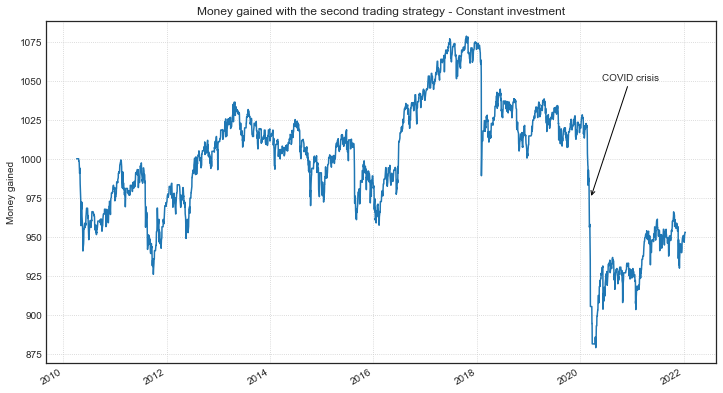

In [349]:
UX2['Money_STR2a'] = money_2

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

UX2.Money_STR2a.plot( ax = ax )
ax.set_title( 'Money gained with the second trading strategy - Constant investment' )
ax.set_xlabel( '' )
ax.set_ylabel( 'Money gained' )
ax.grid( linestyle = 'dotted' )

ax.annotate( "COVID crisis", xy = ( '2020-03-15', 975 ), xytext = ( '2020-06-01', 1050 ),
             arrowprops = dict( arrowstyle = "->" ) )

plt.show()

In [350]:
money_2 = np.zeros( shape = ( len( UX2['PX_LAST'] ) ) )
money_2[0] = 1000
for x in range( 1, len( UX2['PX_LAST'] ) ):
    if UX2['open/close_2'].iloc[x] == 'open':
        if UX2['PX_LAST'].iloc[x] > 20:
            d = 1.5
        else:
            d = 15
        money_2[x] = money_2[x-1] + money_2[x-1] / d * np.tanh( UX2['diff_sim'].iloc[x] / d ) * ( ( UX2['PX_LAST'].iloc[x] - UX2['PX_LAST'].iloc[x+1] ) / UX2['PX_LAST'].iloc[x] )
    else:
        money_2[x] = money_2[x-1]

In [351]:
money_real_2 = np.zeros( shape = ( len( UX2['PX_LAST'] ) ) )
money_real_2[0] = 1000
for x in range( 1, len( UX2['PX_LAST'] ) ):
    if UX2['open/close_real_2'].iloc[x] == 'open':
        if UX2['PX_LAST'].iloc[x] > 20:
            d = 1.5
        else:
            d = 15
        money_real_2[x] = money_real_2[x-1] + money_real_2[x-1] / d * np.tanh( UX2['diff_sim_real'].iloc[x] / d ) * ( ( UX2['PX_LAST'].iloc[x] - UX2['PX_LAST'].iloc[x+1] ) / UX2['PX_LAST'].iloc[x] )
    else:
        money_real_2[x] = money_real_2[x-1]

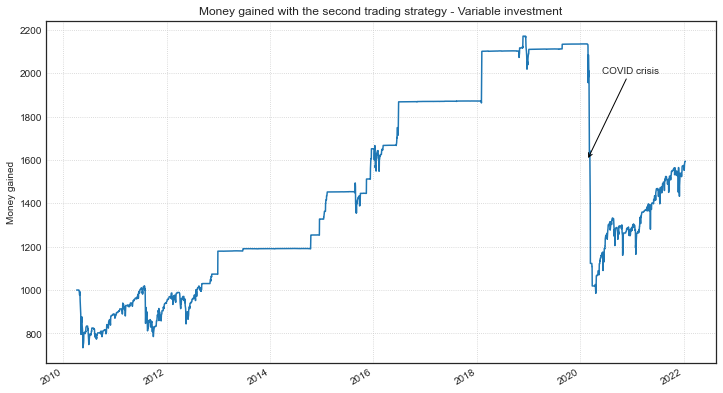

In [352]:
UX2['Money_STR2b'] = money_2

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

UX2.Money_STR2b.plot( ax = ax )
ax.set_title( 'Money gained with the second trading strategy - Variable investment' )
ax.set_xlabel( '' )
ax.set_ylabel( 'Money gained' )
ax.grid( linestyle = 'dotted' )

ax.annotate( "COVID crisis", xy = ( '2020-02-20', 1600 ), xytext = ( '2020-06-01', 2000 ),
             arrowprops = dict( arrowstyle = "->" ) )

plt.show()